In [1]:
import random
import h5py
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler
import math
import random
import copy
import os.path

# User Input Desired Settings

In [4]:
# change file directory to the .h5 data file to convert
file = h5py.File('data/output_digi_HDF_Mg22_Ne20pp_8MeV.h5', 'r')

original_keys = list(file.keys())
original_length = len(original_keys)
# print(original_keys)

In [5]:
#making an array of the lengths of events
event_lens = np.zeros(original_length, int)
for i in range(original_length):
    event = original_keys[i]
    event_lens[i] = len(file[event])

discards = 0
for i in event_lens:
    if i < 128:
        discards += 1

print(discards)

6642


In [4]:
sample_size = 128 #enter the size to which events will be up/downsampled

# designed for data in the following format:
# x[0] ,y[1] ,z[2] ,time[3], Amplitude[4], trackID (particle ID)[5], pointID[6]
# energy[7] ,energy loss[8] ,angle[9], Mass[10], Atomic number[11], Event_id index[12], number of tracks[13]
# ^ this is thus designed for simulated data, as much of this will not be known for experimental data.

# Enter in the CLASSIFICATION and PROJECTIONS to evaluate in all caps as projection:
# B is BINARY, T is tertiary, and FOUR is four track classiification
# Set TRACK_CLASS to true if performing track classification (i.e. using scannet) and to false if performing event
# classification (i.e. using modelnet)
TRACK_CLASS = False
class_type = 'BINARY' # type of track classification
PROJECTION = 'XYZQ' # the three dimensions which will be input into the model
ISOTOPE = 'Mg22'
PROJ_TO_COLS = [0,1,2,4,5,12,13]

PROJ_TO_COLS = {'XYZQ' : [0,1,2,4,5,12,13], 'XYZ': [0,1,2,5,12,13], 'XYQ': [0,1,4,5,12,13], 'XZQ': [0,2,4,5,12,13], 'YZQ': [1,2,4,5,12,13]}

user_input = PROJ_TO_COLS[PROJECTION]
print('TRACK CLASSIFICATION' if TRACK_CLASS else 'EVENT CLASSIFICATION')
print(class_type)
print(user_input)

EVENT CLASSIFICATION
BINARY
[0, 1, 2, 4, 5, 12, 13]


# Convert Raw H5 File into npArray with Corresponding key index

In [5]:
#making a numpy array of the data. three dimension are [event number, point within event, data value at point]
#length of each event is based on the longest event in dataset, so non-maximal events are padded with zeros at the end
#12th index of each data point now corresponds to the index of the event in the h5 file's original_keys
# each point thus contains:
# x,y,z, time, Amplitude, trackID (particle ID), pointID, energy, energy loss, angle, Mass, Atomic number, Event_id index
file_name = ISOTOPE + '_w_key_index'
# **only doing this if the file doens't exist already, as the conversion takes a while**
if not os.path.exists('data/' + file_name + '.npy'):
    event_data = np.zeros((original_length, np.max(event_lens), 13), float) 
    for n in range(len(original_keys)):
        name = original_keys[n]
        event = file[name]
        ev_len = len(event)
        #converting event into an array
        for i,e in enumerate(event):
            instant = np.array(list(e))
            event_data[n][i][:12] = np.array(instant)
            event_data[n][i][-1] = float(n) #insert index value to find corresponding event ID
    np.save('data/' + file_name, event_data)

### Assertion Statements to Check the Conversion

In [6]:
data = np.load( 'data/' + ISOTOPE + '_w_key_index' + '.npy')
assert data.shape == (original_length, np.max(event_lens), 13), 'Array has incorrect shape'
assert len(np.unique(data[:,:,12])) == original_length, 'Array has incorrect Event_ids'

# Random sample From New Numpy Array

In [7]:
#adding 13th column to correspond to the number of tracks in event, zero-indexed: 0 = beam, 1= two track, 2 = 3 track...
data_array = ISOTOPE + '_w_key_index.npy' #insert desired array to sample from 
new_array_name = ISOTOPE + '_size' + str(sample_size) + '_sampled'
data = np.load('data/' + data_array)
new_data = np.zeros((original_length, sample_size, 14), float)
count = 0
for i in range(original_length):
    ev_len = event_lens[i]    #length of event-- i.e. number of points
    particle_ids = data[i][:ev_len,5]
    label, distr = np.unique(particle_ids, return_counts=True)
    shortest = label[np.argmin(distr)]
    shortest_ind = np.argwhere(particle_ids == shortest)
    if ev_len == sample_size:    #if array is already preferred length
        new_data[i][:,:-1] = data[i][:ev_len,:]

    else:
        instant = 0
        #the first instances sampled will be those belonging to the shortest track to prevent it from being lost
        for n in range(shortest_ind.size):
            new_data[i,instant,:-1] = data[i,shortest_ind[n],:]
            instant += 1
        #     assert instant < 128, 'If instant >= 128 IndexError will occur'
        need = sample_size #- shortest_ind.size
        random_points = np.random.choice(range(ev_len), need, replace= True if need > ev_len else False)  #choosing random instances to sample
        for r in random_points:
            new_data[i,instant,:-1] = data[i,r,:] 
            instant += 1
        # assert instant <= 128, 'If instant >= 128 IndexError will occur'
    unique_point_ids = np.unique(data[i,:ev_len,5])    #array of unique particle IDs
    new_data[i][0][-1] = unique_point_ids.size - 1    #number of unique particles, scaled to start at 0
# np.save('data/' + new_array_name, new_data) 
print(new_data.shape)

(10000, 128, 14)


In [8]:
idxs = []
for i in range(len(new_data)):

    if new_data[i][:, :-1].any() == np.zeros((128, 13)).all():
        idxs.append(i)

idxs = np.asarray(idxs)

# print(len(idxs))
# print(count)
assert len(idxs) == count

cut_new_data = np.ndarray((len(new_data)-len(idxs), 128, 14))

inc = 0

for i in range(len(new_data)):

    if i not in idxs:
        cut_new_data[inc] = new_data[i]
        inc += 1


np.save('data/' + new_array_name, cut_new_data) 
print(cut_new_data.shape)

(3358, 128, 14)


### Assertion Statements to Check the Data After Random Sampling

In [9]:
data = np.load( 'data/' + ISOTOPE + '_size' + str(sample_size) + '_sampled.npy')
assert data.shape == (original_length-count, sample_size, 14), 'Array has incorrect shape -- '+str(data.shape)
assert len(np.unique(data[:,:,13])) == len(np.unique(data[:,:,5]))-1, 'Array has incorrect number of tracks'

AssertionError: Array has incorrect number of tracks

### Check Distribution of labels after sampling

In [12]:
#cheking how the distribution of labels changes from sampling
name = ISOTOPE + '_size' + str(sample_size) + '_sampled'
data = np.load('data/' + name + '.npy')
real_tracks = np.zeros(original_length,int) 
sampled_tracks = np.zeros(original_length,int)

for i in range(original_length-count):
    ev_nt = data[i]
    real_tracks[i] = ev_nt[0,-1]
    unique_point_ids = np.unique(ev_nt[:,5])    #array of unqiue particles IDs
    sampled_tracks[i] = unique_point_ids.size - 1
    
og_label, og_distr = np.unique(real_tracks, return_counts=True)
new_label, new_distr = np.unique(sampled_tracks, return_counts=True)
print(og_label, new_label)
print(og_distr)
print(new_distr)
# number of events that have lost a track from sampling. not a big deal if nonzero
print('Events changed = ' + str(np.sum(np.abs(new_distr - og_distr))//2)) 

[0 1 2 3 4 5] [0 1 2 3 4 5]
[6643   73  948 2315   16    5]
[6652  156 1226 1951   12    3]
Events changed = 370


# Create Filtered npArrays
For track classification, focusing on 4-track events.

In [ ]:
assert TRACK_CLASS, 'only do this for track classification'
file_name = ISOTOPE + '_size' + str(sample_size) + '_sampled' #insert desired file name to open
raw_data = np.load('data/' + file_name + '.npy')
new_file_name = ISOTOPE + '_4-track_size' + str(sample_size)
count = 0
new_data = np.zeros((original_length, sample_size, 14), float)

for i in range(original_length):
    new_event = raw_data[i]
    unique_point_ids = np.unique(new_event[:,5])    
    current_tracks = unique_point_ids.size - 1 
    og_tracks = new_event[0,-1]
    
    #omitting non-4-track events, mislabeled events, and that one event with a particle ID 4
    if og_tracks != 3 or og_tracks != current_tracks or 5 in unique_point_ids:
        continue
    else:
        new_event[:,5] -= 1 # lowering particle id to start from 0
        new_data[count,:,:] = new_event
        count += 1
    
print(count)
saving = new_data[:count, :,:]
np.save('data/' + new_file_name, saving) #creating new np array

### Assertion Statements to Check the Data After Filtering Tracks 

In [ ]:
if TRACK_CLASS:
    data = np.load( 'data/' + ISOTOPE + '_4-track_size' + str(sample_size)+ '.npy')
    print(list(np.unique(data[:,:,5])))
    assert data.shape == (count, sample_size, 14), 'Array has incorrect shape'
    assert list(np.unique(data[:,:,5])) == [0.0, 1.0, 2.0, 3.0], 'Array has incorrect particle ids'
    assert len(np.unique(data[:,:,5])) == 4, 'Array has incorrect number of particle ids'
    assert list(np.unique(saving[:,0,13])) == [3.0], 'Array has incorrect type of events'

### Check Distribution of Event Types After Filtering Tracks

In [13]:
if TRACK_CLASS:
    name = ISOTOPE + '_4-track_size' + str(sample_size)
else:
    name = ISOTOPE + '_size' + str(sample_size) + '_sampled'
data = np.load('data/' + name + '.npy')
real_tracks = np.zeros(len(data),int)
sampled_tracks = np.zeros(len(data),int)

for i in range(len(data)):
    ev_nt = data[i]
    real_tracks[i] = ev_nt[0,-1] # original event label
    unique_point_ids = np.unique(ev_nt[:,5])    # array of unqiue particles IDs-- i.e current event label after sampling
    sampled_tracks[i] = unique_point_ids.size - 1
    
label, og_distr = np.unique(real_tracks, return_counts=True)
label, new_distr = np.unique(sampled_tracks, return_counts=True)

print(list(np.unique(data[:,:,5]))) # Particles present in data
print(list(np.unique(data[:,:,13]))) # types of events present in data
print(og_distr) 
print(new_distr) 
unique_point_id = np.unique(data[:,:,5])
print((unique_point_id)) # uncomment to check particle ids
assert (np.sum(np.abs(new_distr - og_distr))) == 0, 'Event labels do not match actual event types'

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[   1   73  948 2315   16    5]
[  10  156 1226 1951   12    3]
[1. 2. 3. 4. 5. 6.]


AssertionError: Event labels do not match actual event types

# Binary, Tertiary, and Other Classification
### *Skip this step if doing event classification*

In [ ]:
#a function to adjust point labels based on track classification type, with particle 0 being the alpha
# No need to do this step if doing event classification
if TRACK_CLASS:
    if class_type == 'BINARY':
        def alpha(p):
            if int(p) == 0:
                return 0
            else:
                return 1
    elif class_type == 'TERTIARY':
        def alpha(p):
                if int(p) == 0:
                    return 0
                elif int(p) == 1:
                    return 1
                else:
                    return 2

In [ ]:
# No need to do this step if doing event classification
#adjusting particle IDs
if TRACK_CLASS:
    if class_type == 'BINARY' or class_type == 'TERTIARY':
        name = ISOTOPE + '_4-track_size' + str(sample_size)
        data = np.load('data/' + name + '.npy')
        new_classification = np.zeros((len(data), sample_size, 14), float)
        for i in tqdm.tqdm(range(len(data))):
            event = data[i]
            new_event = event[:,:]
            new_event[:,5] = list(map(alpha, event[:,5]))
            new_classification[i,:,:] = new_event[:,:]
    np.save('data/' + name, new_classification)
    print(data.shape)

# Split Testing Set, Training Set, and Validation Set

## Split Training and Testing Sets

Performs a 20-test 20-val 60-train split on all 4-track events, and generates an array of numbers as long as the length of the data to randomize the events. 

In [14]:
if TRACK_CLASS:
    name = ISOTOPE + '_4-track_size' + str(sample_size)
    all_events = np.load('data/' + name + '.npy')
else:
    name = ISOTOPE + '_size' + str(sample_size)
    all_events = np.load('data/' + name + '_sampled.npy')

rand_shuffle = np.random.choice(len(all_events), len(all_events), replace = False)


# 20-20 marking for test and validation
test_split = int(len(all_events) * .2)
val_split = int(len(all_events) * .4)

if TRACK_CLASS:
    test_event_indices =  all_events[rand_shuffle[:test_split],:,-2:]    #only saving the indices and number of tracks of the test events
else:
    test_data = all_events[rand_shuffle[:test_split],:,:]
val_data = all_events[rand_shuffle[test_split:val_split],:,:]
train_data = all_events[rand_shuffle[val_split:],:,:]


if TRACK_CLASS:
    print(test_event_indices.shape, val_data.shape, train_data.shape)
    np.save('data/{}_4-track_testevent_indices'.format(ISOTOPE), test_event_indices)
else:
    print(test_data.shape, val_data.shape, train_data.shape)
    np.save('data/' + name + 'test', test_data)
np.save('data/' + name + 'train', train_data)
np.save('data/' + name + 'val', val_data)

(671, 128, 14) (672, 128, 14) (2015, 128, 14)


# Making Test Sets
#### We make a pair of test sets to span all the data points, ensuring that each point is tested. This is useful for testing events that have been downsampled.
*This is only necessary for semantic segmentation.*

In [ ]:
#making an array of the 4-track test event lengths
if TRACK_CLASS:
    name = ISOTOPE + '_4-track'
    ev_indices = np.load('data/' + name + '_testevent_indices.npy')
    num_events = ev_indices.shape[0]
    test_ev_lens = np.zeros(num_events,int)
    for i in tqdm.tqdm(range(num_events)):
        event_ind = int(ev_indices[i,0,0])
        test_ev_lens[i] = event_lens[event_ind]
    np.save('data/' + name + '_testevent_lengths', test_ev_lens)
    print(np.max(test_ev_lens))

In [ ]:
#making an array of all the 4-track test data
if TRACK_CLASS:
    data = np.load('data/' + ISOTOPE + '_w_key_index.npy')
    num_events = ev_indices.shape[0]
    test_data = np.zeros((num_events,np.max(test_ev_lens),14),float)
    instant = 0
    for i in tqdm.tqdm(range(num_events)):
        event_ind = int(ev_indices[i,0,0])
        test_data[instant,:,:-1] = data[event_ind,:np.max(test_ev_lens),:]
        test_data[instant,0,-1] = ev_indices[i,0,1]
        test_data[instant,:,5] -= 1   #scaling the labels so they start at 0
        instant += 1
    np.save('data/' + name + '_testevents', test_data)

In [ ]:
#making a normal sampled test dataset
if TRACK_CLASS:
    name = ISOTOPE + '_4-track'
    test_events = np.load('data/' + name + '_testevent_indices.npy')
    num_events = test_data.shape[0]
    test_sample = np.zeros((num_events,sample_size,14),float)
    incl_points = np.zeros((num_events,sample_size),int)
    for i in range(num_events):
        ev_len = test_ev_lens[i]    #accessing the event index to find event length
        particle_ids = test_data[i,:ev_len,5]
        label, distr = np.unique(particle_ids, return_counts=True)
        shortest = label[np.argmin(distr)]
        shortest_ind = np.argwhere(particle_ids == shortest)
        if ev_len == sample_size:    #if array is already preferred length
            test_sample[i,:,:] = test_data[i,:ev_len,:]
            incl_points[i,:] = range(sample_size)
        else:
            instant = 0
            for n in range(shortest_ind.size):    #the first instances sampled will be those belonging to the shortest track
                test_sample[i,instant,:] = test_data[i,shortest_ind[n],:]
                incl_points[i,instant] = shortest_ind[n]
                instant += 1
            need = sample_size - shortest_ind.size
            random_points = np.random.choice(range(ev_len), need, replace= True if need > ev_len else False)  #choosing the random instances to sample
            for r in random_points:
                test_sample[i,instant,:] = test_data[i,r,:] 
                incl_points[i,instant] = r
                instant += 1
        test_sample[i,:,6] = incl_points[i,:]    #storing the indices in the original event as point IDs
        test_sample[i,:,5] = list(map(alpha, test_sample[i,:,5]))    #making it BINARY
    np.save('data/' + name + '_size{}test1'.format(sample_size), test_sample)

    #array of the number of points not included in the first sample
    not_incl = np.zeros(num_events, int)
    for i in range(num_events):
        incl = np.unique(incl_points[i])
        not_incl[i] = event_lens[int(test_data[i,0,-2])] - incl.size
    
    #indices of the points not included in the first sample
    not_incl_points = np.zeros((num_events,np.max(not_incl)),int)
    for i in range(num_events):    #going through each event
        count = 0
        for p in range(event_lens[int(test_data[i,0,-2])]):    #going through each instant in the event
            if p not in incl_points[i]:    #if that instant is not in the included points for that event
                not_incl_points[i, count] = p
                count += 1

In [ ]:
#making a second test dataset that includes the points not in the first test dataset
if TRACK_CLASS:
    name = ISOTOPE + '_4-track'
    test_data = np.load('data/' + name + '_testevents.npy')
    num_events = test_data.shape[0]
    test_sample = np.zeros((num_events,sample_size,14),float)
    incl_points = np.zeros((num_events,sample_size),int)
    for i in range(num_events):
        ev_len = test_ev_lens[i]    #accessing the event index to find event length
        particle_ids = test_data[i,:event_lens[i],5]
        label, distr = np.unique(particle_ids, return_counts=True)
        shortest = label[np.argmin(distr)]
        shortest_ind = np.argwhere(particle_ids == shortest)
        indices_sampled = np.zeros(sample_size, int)
        if ev_len == sample_size:    #if array is already preferred length
            test_sample[i,:,:] = test_data[i,:ev_len,:]
            indices_sampled = range(sample_size)
        else:
            instant = 0
            # including points not in the first set
            for n in range(not_incl[i]):
                test_sample[i,instant,:] = test_data[i,not_incl_points[i,n],:]
                indices_sampled[instant] = not_incl_points[i,n]
                instant += 1
            if shortest_ind.size + not_incl[i] > sample_size:
                #including as many points of shortest track as possible
                for n in range(sample_size - not_incl[i]):    
                    test_sample[i,instant,:] = test_data[i,shortest_ind[n],:]
                    indices_sampled[instant] = shortest_ind[n]
                    instant += 1
            else:
                #including all of shortest track
                for n in range(shortest_ind.size):    
                    test_sample[i,instant,:] = test_data[i,shortest_ind[n],:]
                    indices_sampled[instant] = shortest_ind[n]
                    instant += 1
                random_points = np.random.choice(range(ev_len), sample_size - shortest_ind.size - not_incl[i])
                #randomly sampling to get up to sample size
                for r in random_points:
                    test_sample[i,instant,:] = test_data[i,r,:]
                    indices_sampled[instant] = r
                    instant += 1
        test_sample[i,:,6] = indices_sampled[:]    #storing the indices in the original event as point IDs
        test_sample[i,:,5] = list(map(alpha, test_sample[i,:,5]))   
    np.save('data/' + name + '_size{}test2'.format(sample_size), test_sample)

### Checks

In [15]:
if TRACK_CLASS:
    name = 'data/' + ISOTOPE + '_4-track_size' + str(sample_size) + '{}.npy'
    prev_data = np.load(name.format(''))
    tr = np.load(name.format('train'))
    va = np.load(name.format('val'))
    te1 = np.load(name.format('test1'))
    te2 = np.load(name.format('test2'))
    print(len(prev_data))
    print(tr.shape, va.shape, te1.shape, te2.shape)
    print(len(np.unique(tr[:,:,5])))
    print(len(np.unique(va[:,:,12])))
    print(len(np.unique(te1[:,:,12])))
    print(len(np.unique(te2[:,:,12])))
else:
    name = 'data/' + ISOTOPE + '_size' + str(sample_size) + '{}.npy'
    prev_data = np.load(name.format('_sampled'))
    tr = np.load(name.format('train'))
    va = np.load(name.format('val'))
    te = np.load(name.format('test'))
    print(len(prev_data))
    print(tr.shape, va.shape, te.shape)
    print(len(np.unique(tr[:,:,5])))
    print(len(np.unique(va[:,:,12])))
    print(len(np.unique(te[:,:,12])))

# works perfectly if length of dataset is even; if odd, rounding may be off
# assert tr.shape == (np.ceil(len(prev_data) * .6) , sample_size, 14), 'Array has incorrect shape, check first for rounding error.'
# assert va.shape == (np.ceil(len(prev_data) * .2) , sample_size, 14), 'Array has incorrect shape, check first for rounding error.'
# assert te.shape == (np.ceil(len(prev_data) * .2) , sample_size, 14), 'Array has incorrect shape, check first for rounding error.'
print(len(prev_data))
if TRACK_CLASS:
    print(tr.shape, va.shape, te1.shape, te2.shape)
else:
    print(tr.shape, va.shape, te.shape)
print(len(np.unique(tr[:,:,5])))

3358
(2015, 128, 14) (672, 128, 14) (671, 128, 14)
6
672
671
3358
(2015, 128, 14) (672, 128, 14) (671, 128, 14)
6


# Rescaling 

In [16]:
assert len(np.unique(np.isnan(tr[:,:,4]))) == 1, 'NaNs in dataset'
assert len(np.unique(np.isnan(va[:,:,4]))) == 1, 'NaNs in dataset'
if TRACK_CLASS:
    assert len(np.unique(np.isnan(te1[:,:,4]))) == 1, 'NaNs in dataset'
    assert len(np.unique(np.isnan(te2[:,:,4]))) == 1, 'NaNs in dataset'
else:
    assert len(np.unique(np.isnan(te[:,:,4]))) == 1, 'NaNs in dataset'
assert np.any(tr[:,:,4]<0) == False, 'Dataset is incorrect, Negative charge values'
assert np.any(va[:,:,4]<0) == False, 'Dataset is incorrect, Negative charge values'
if TRACK_CLASS:
    assert np.any(te1[:,:,4]<0) == False, 'Dataset is incorrect, Negative charge values'
    assert np.any(te2[:,:,4]<0) == False, 'Dataset is incorrect, Negative charge values'
else:
    assert np.any(te[:,:,4]<0) == False, 'Dataset is incorrect, Negative charge values'

scaled_val_data = copy.deepcopy(va)
scaled_train_data = copy.deepcopy(tr)
if TRACK_CLASS:
    scaled_test_data1 = copy.deepcopy(te1)
    scaled_test_data2 = copy.deepcopy(te2)
else:
    scaled_test_data = copy.deepcopy(te)
# checking shapes
if TRACK_CLASS:
    print(scaled_test_data1.shape, scaled_test_data2.shape, scaled_train_data.shape, scaled_val_data.shape)
else:
    print(scaled_test_data.shape, scaled_train_data.shape, scaled_val_data.shape)

(671, 128, 14) (2015, 128, 14) (672, 128, 14)


In [17]:
# log scale all charges to reduce large range of values
if TRACK_CLASS:
    scaled_test_data1[:,:,4] = np.log10(te1[:,:,4] + 1e-10)
    scaled_test_data2[:,:,4] = np.log10(te2[:,:,4] + 1e-10)
else:
    scaled_test_data[:,:,4] = np.log10(te[:,:,4] + 1e-10)
scaled_train_data[:,:,4] = np.log10(tr[:,:,4] + 1e-10)
scaled_val_data[:,:,4] = np.log10(va[:,:,4] + 1e-10)

In [18]:
# values correspond to the x,y,z,charge indices
values = [0,1,2,4] 
means_and_stds = []
# standard scaling 
for n in values:
    mean = np.mean(scaled_train_data[:,:,n])
    std = np.std(scaled_train_data[:,:,n])
    means_and_stds.append([mean,std])
    scaled_train_data[:,:,n] = (scaled_train_data[:,:,n] - mean) / std
    scaled_val_data[:,:,n] = (scaled_val_data[:,:,n] - mean) / std
    if TRACK_CLASS:
        scaled_test_data1[:,:,n] = (scaled_test_data1[:,:,n] - mean) / std
        scaled_test_data2[:,:,n] = (scaled_test_data2[:,:,n] - mean) / std
    else:
        scaled_test_data[:,:,n] = (scaled_test_data[:,:,n] - mean) / std

if TRACK_CLASS:
    name = 'data/' + ISOTOPE + '_4-track_size' + str(sample_size) + 'scaled_{}'
    np.save(name.format('test_data1'), scaled_test_data1)
    np.save(name.format('test_data2'), scaled_test_data2)
else:
    name = 'data/' + ISOTOPE + '_size' + str(sample_size) + 'scaled_{}'
    np.save(name.format('test_data'), scaled_test_data)
    
np.save(name.format('mean_and_std_data'), means_and_stds)    
np.save(name.format('train_data'), scaled_train_data)
np.save(name.format('val_data'), scaled_val_data)

In [19]:
assert np.sum(np.isnan(scaled_train_data)) == 0, 'NaNs in dataset'
assert np.sum(np.isnan(scaled_val_data)) == 0, 'NaNs in dataset'
if TRACK_CLASS:
    assert np.sum(np.isnan(scaled_test_data1)) == 0, 'NaNs in dataset'
    assert np.sum(np.isnan(scaled_test_data2)) == 0, 'NaNs in dataset'
else:
    assert np.sum(np.isnan(scaled_test_data)) == 0, 'NaNs in dataset'
    
assert np.sum(np.isinf(scaled_train_data)) == 0, 'Infinities in dataset'
assert np.sum(np.isinf(scaled_val_data)) == 0, 'Infinities in dataset'
if TRACK_CLASS:
    assert np.sum(np.isinf(scaled_test_data1)) == 0, 'Infinities in dataset'
    assert np.sum(np.isinf(scaled_test_data2)) == 0, 'Infinities in dataset'
else:
    assert np.sum(np.isinf(scaled_test_data)) == 0, 'Infinities in dataset'

# Get User Desired Inputs and make condensed array 
#### including x/y/z/c values, and then particle ID, event index, and number of tracks

In [20]:
new_train = np.zeros((len(scaled_train_data), sample_size, len(user_input)), float)
new_val = np.zeros((len(scaled_val_data), sample_size, len(user_input)), float)
if TRACK_CLASS:
    new_test1 = np.zeros((len(scaled_test_data1), sample_size, len(user_input) + 1), float)
    new_test2 = np.zeros((len(scaled_test_data2), sample_size, len(user_input) + 1), float)
else:
    new_test = np.zeros((len(scaled_test_data), sample_size, len(user_input) + 1), float)


for i,index in enumerate(user_input):
    new_train[:,:,i] = scaled_train_data[:,:,index]
    new_val[:,:,i] = scaled_val_data[:,:,index]
    if TRACK_CLASS:
        new_test1[:,:,i] = scaled_test_data1[:,:,index]
        new_test2[:,:,i] = scaled_test_data2[:,:,index]
    else:
        new_test[:,:,i] = scaled_test_data[:,:,index]
        
if TRACK_CLASS:
    new_test1[:,:,-1] = scaled_test_data1[:,:,6]    #saving the POINT IDs (different from particle IDs)
    new_test2[:,:,-1] = scaled_test_data2[:,:,6]
else:
    new_test[:,:,-1] = scaled_test_data[:,:,6]    #saving the POINT IDs (different from particle IDs)

if TRACK_CLASS:
    name = 'data/' + ISOTOPE + '_4-track_size' + str(sample_size) + '_convert' + PROJECTION + '_{}'
else:
    name = 'data/' + ISOTOPE + '_size' + str(sample_size) + '_convert' + PROJECTION + '_{}'

np.save(name.format('train'), new_train)
np.save(name.format('val'), new_val)

if TRACK_CLASS:
    np.save(name.format('test1'), new_test1)
    np.save(name.format('test2'), new_test2)
else:
    np.save(name.format('test'), new_test)

In [21]:
# Checking shape after creating
print(new_train.shape)
print(new_val.shape)
if TRACK_CLASS:
    print(new_train[0,0,:])
    print(new_test1.shape)
    print(new_test2.shape)
    
else:
    print(new_test.shape)
print(new_val[0,0])
print(new_train[0,0])

assert np.sum(np.isnan(new_train)) == 0, 'NaNs in dataset'
assert np.sum(np.isnan(new_val)) == 0, 'NaNs in dataset'
if TRACK_CLASS:
    assert np.sum(np.isnan(new_test1)) == 0, 'NaNs in dataset'
    assert np.sum(np.isnan(new_test2)) == 0, 'NaNs in dataset'
else:
    assert np.sum(np.isnan(new_test)) == 0, 'NaNs in dataset'
    
assert np.sum(np.isinf(new_train)) == 0, 'Infinities in dataset'
assert np.sum(np.isinf(new_val)) == 0, 'Infinities in dataset'
if TRACK_CLASS:
    assert np.sum(np.isinf(new_test1)) == 0, 'Infinities in dataset'
    assert np.sum(np.isinf(new_test2)) == 0, 'Infinities in dataset'
else:
    assert np.sum(np.isinf(new_test)) == 0, 'Infinities in dataset'

(2015, 128, 7)
(672, 128, 7)
(671, 128, 8)
[ 4.27480579e-01 -8.01962178e-01  8.32781631e-01  3.02437847e-01
  4.00000000e+00  5.69400000e+03  2.00000000e+00]
[ 6.15746396e-01 -1.82605257e+00 -3.85121370e-01  1.89267296e+00
  1.00000000e+00  9.68600000e+03  3.00000000e+00]


# Make Histogram

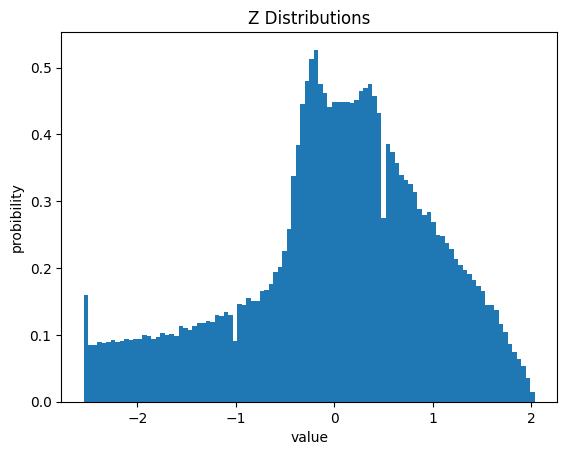

In [22]:
# Make histogram of values (either x,y,z,charge) from selected npy (train, val, test)
# Will need to change PLOT and DATA_SET_NAME to plot X-Y-Z-Q(charge) from training, val, or test
PLOT = 'Z'
DATA_SET_NAME = '_train'
index = PROJECTION.find(PLOT)

if index != -1:
    if TRACK_CLASS:
        data = np.load('data/' + ISOTOPE + '_4-track_size' + str(sample_size) + '_convert' + PROJECTION + DATA_SET_NAME + '.npy')
    else:
        data = np.load('data/' + ISOTOPE + '_size' + str(sample_size) + '_convert' + PROJECTION + DATA_SET_NAME + '.npy')
    info = data[:,:,index].flatten()
    plt.hist(info, density=True, bins=100)
    plt.ylabel('probibility')
    plt.xlabel('value')
    plt.title(PLOT + ' Distributions')
    plt.show()
    # plt.savefig('data/'+ '.png', bbox_inches = 'tight') # uncomment to save
else:
    print('Value to plot is invalid, change PLOT')